In [1]:
from fastai.vision.all import *
import torch.nn as nn
import torch.nn.functional as F


In [2]:
assert nn.Module, "PyTorch nn.Module not imported."
assert F.cross_entropy, "PyTorch F.cross_entropy not imported."
assert ImageDataLoaders, "Fastai ImageDataLoaders not imported."

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
from pathlib import Path
assert Path(path/'training').exists(), "Training data folder doesn't exist"
assert Path(path/'testing').exists(), "Testing data folder doesn't exist"

In [5]:
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing')

/home/john/mambaforge/envs/scratch/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


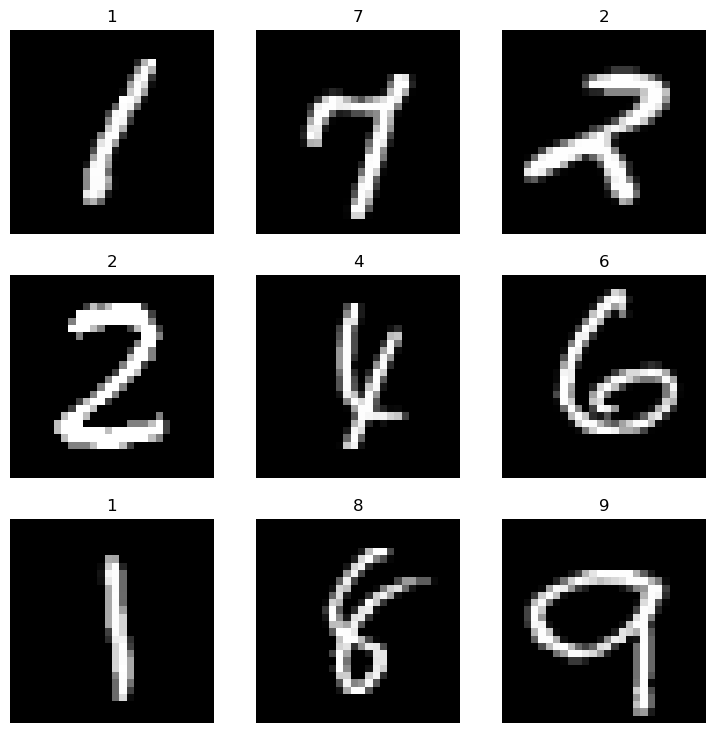

In [6]:
dls.show_batch()

In [7]:
print(dls.vocab, len(dls.train), len(dls.valid))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] 937 157


In [8]:

class SimpleModel(nn.Module):
    def __init__(self, in_features, hidden1, hidden2, out_features):
        super(SimpleModel, self).__init__()
        
        self.fc1 = nn.Linear(in_features, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, out_features)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# Get the number of input features and output classes
print(dls.one_batch()[0].shape)
in_features = dls.one_batch()[0].shape[1] * dls.one_batch()[0].shape[2] * dls.one_batch()[0].shape[3]
out_features = len(dls.vocab)
print("in:", in_features)
print("out:", out_features)

# Initialize model
device = torch.device("cuda:0")
model = SimpleModel(in_features, 128, 64, out_features).to(device)



torch.Size([64, 3, 28, 28])
in: 2352
out: 10


In [10]:
# Create fastai learner and train
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.246849,0.225618,0.934000,01:29
1,0.135626,0.118556,0.964300,01:07
2,0.085546,0.091166,0.971900,01:06
3,0.054441,0.077397,0.975700,01:05
4,0.035664,0.071071,0.977800,01:05


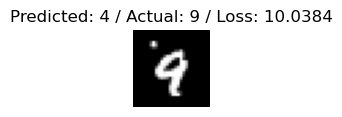

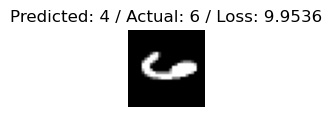

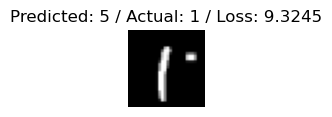

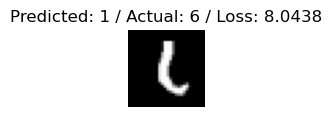

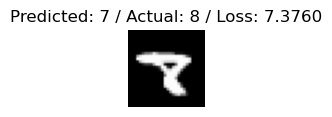

In [13]:
# Let's inspect the images of the greatest loss

# Get predictions and corresponding losses for the validation set
preds, targets, losses = learn.get_preds(with_loss=True)

# Sort the indices of the losses
sorted_idx = losses.argsort(descending=True)

# Show the images with the top N highest losses
for i in sorted_idx[:5]:
    img, label = dls.valid_ds[i]
    img.show(title=f'Predicted: {dls.vocab[preds[i].argmax()]} / Actual: {dls.vocab[label]} / Loss: {losses[i]:.4f}')


In [14]:
# Get raw predictions (logits)
preds, targets = learn.get_preds()

# Convert logits to softmax probabilities
probs = F.softmax(preds, dim=1)

# Identify correct predictions
correct_preds = (probs.argmax(dim=1) == targets)

# For each correct prediction, get the max probability (confidence)
correct_confidences = probs[correct_preds].max(dim=1)[0]

# Find indices of lowest confidence but correct predictions
lowest_conf_idx = correct_confidences.argsort()[:5]

# Get original indices from the validation set
original_indices = torch.nonzero(correct_preds).squeeze()[lowest_conf_idx]

# Show these images
for i in original_indices:
    img, label = dls.valid_ds[i]
    img.show(title=f'Predicted: {dls.vocab[preds[i].argmax()]} / Actual: {dls.vocab[label]} / Confidence: {probs[i][label]:.4f}')


TypeError: unsupported format string passed to TensorCategory.__format__